Github link to the project: https://github.com/go-gle/Hi5_22

In [1]:
import pandas as pd

from preprocessing.utils import uncorr_numerical, categorical_features, dates_features, TARGET
from feature_generation.time_generation import TimeFeaturesMonth, TimeFeaturesWeek, TimeFeaturesYear, TimeFeaturesSeason

In [2]:
features = uncorr_numerical + categorical_features + dates_features 
cols = features + [TARGET, 'row_index']

len(features)

64

In [3]:
import pickle

with open('pipe.pickle', 'rb') as handle:
    pipe = pickle.load(handle)

In [43]:
%%time 
df = pd.read_csv('X_train_Hi5_1.csv', usecols=cols)

test = pd.read_csv('X_test_Hi5.csv', usecols=features  + ['row_index'])

<timed exec>:1: DtypeWarning: Columns (110,111,117,118,124,125) have mixed types. Specify dtype option on import or set low_memory=False.
<timed exec>:3: DtypeWarning: Columns (1,110,111,117,118,124,125) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 52.5 s, sys: 6.02 s, total: 58.5 s
Wall time: 58.5 s


In [44]:
test['piezo_station_department_code'] = test['piezo_station_department_code'].astype('str')
df['piezo_station_department_code'] = df['piezo_station_department_code'].astype('str')

In [45]:
df = pipe.transform(df)
test = pipe.transform(test)
df.shape, test.shape

100%|██████████| 61/61 [00:08<00:00,  7.55it/s]


((2830316, 66), (611208, 65))

In [46]:
group_cols = ['piezo_station_bss_id', 'piezo_measurement_date']
df = df.drop_duplicates(group_cols)
df.shape

(2830072, 66)

In [47]:
feats = uncorr_numerical + categorical_features
df[feats].shape, test[feats].shape

((2830072, 61), (611208, 61))

In [50]:
# Add depth inside the department
group_cols = ['piezo_station_department_code']
agg_col = ['piezo_station_investigation_depth']
sorted_df = pd.concat([df[group_cols + agg_col], test[group_cols  + agg_col]], axis=0).drop_duplicates()
sorted_df = sorted_df.groupby(group_cols)[agg_col[0]].mean().reset_index()
sorted_df = sorted_df.rename(columns={'piezo_station_investigation_depth': 'mean_dep_depth'})
sorted_df

,piezo_station_department_code,mean_dep_depth
0,0,33.263331
1,1,34.502821
2,2,79.031000
3,3,28.651536
4,4,10.485714
...,...,...
89,89,54.185788
90,90,59.909982
91,91,63.181818
92,92,83.400000


In [53]:
print(df.shape)
df = pd.merge(df, sorted_df, on=group_cols, how='left')
print(test.shape)
test = pd.merge(test, sorted_df, on=group_cols, how='left')
print(test.shape, df.shape)

(2830072, 66)
(611208, 65)
(611208, 66) (2830072, 67)


In [54]:
feats = feats + ['mean_dep_depth']
df[feats].shape, test[feats].shape

((2830072, 62), (611208, 62))

In [55]:
from tqdm import tqdm

In [56]:
group_cols = ['piezo_station_department_code', 'piezo_measurement_date']
agg_col = ['prelev_volume_0']
sorted_df = pd.concat([df[group_cols + agg_col], test[group_cols  + agg_col]], axis=0).groupby(group_cols)[agg_col[0]].mean().reset_index()
feats_df = sorted_df[group_cols]   
sorted_df[agg_col] = sorted_df[agg_col].fillna(sorted_df[agg_col].mean())
sorted_df['piezo_measurement_date'] = pd.to_datetime(sorted_df['piezo_measurement_date'])
sorted_df = sorted_df.sort_values(by=group_cols)
sorted_df = sorted_df.set_index('piezo_measurement_date')

for d in tqdm([7, 30, 180, 365]):
    for f in ['min', 'max']:
        if f == 'max':
            t = (sorted_df
             .groupby('piezo_station_department_code')['prelev_volume_0']
             .rolling(window=d, min_periods=1).max().reset_index())
        elif f == 'min':
            t = (sorted_df
             .groupby('piezo_station_department_code')['prelev_volume_0']
             .rolling(window=d, min_periods=1).min().reset_index())
        elif f == 'mean':
            t = (sorted_df
             .groupby('piezo_station_department_code')['prelev_volume_0']
             .rolling(window=d, min_periods=1).mean().reset_index())
    
        t = t.rename(columns={agg_col[0] : f'dep_{agg_col[0]}_{f}_{d}'})
        t['piezo_measurement_date'] = t['piezo_measurement_date'].astype(str)
        feats_df = pd.merge(feats_df, t, on=group_cols, how='left')

feats_df.shape        

100%|██████████| 4/4 [00:02<00:00,  1.97it/s]


(128243, 10)

In [57]:
agg_col = ['prelev_other_volume_sum']
sorted_df = pd.concat([df[group_cols + agg_col], test[group_cols  + agg_col]], axis=0).groupby(group_cols)[agg_col[0]].mean().reset_index()

sorted_df[agg_col] = sorted_df[agg_col].fillna(sorted_df[agg_col].mean())
sorted_df['piezo_measurement_date'] = pd.to_datetime(sorted_df['piezo_measurement_date'])
sorted_df = sorted_df.sort_values(by=group_cols)
sorted_df = sorted_df.set_index('piezo_measurement_date')

for d in tqdm([7, 30, 180, 365]):
    for f in ['min', 'max']:
        if f == 'max':
            t = (sorted_df
             .groupby('piezo_station_department_code')['prelev_other_volume_sum']
             .rolling(window=d, min_periods=1).max().reset_index())
        elif f == 'min':
            t = (sorted_df
             .groupby('piezo_station_department_code')['prelev_other_volume_sum']
             .rolling(window=d, min_periods=1).min().reset_index())
        elif f == 'mean':
            t = (sorted_df
             .groupby('piezo_station_department_code')['prelev_other_volume_sum']
             .rolling(window=d, min_periods=1).mean().reset_index())
    
        t = t.rename(columns={agg_col[0] : f'dep_{agg_col[0]}_{f}_{d}'})
        t['piezo_measurement_date'] = t['piezo_measurement_date'].astype(str)
        feats_df = pd.merge(feats_df, t, on=group_cols, how='left')

feats_df.shape        

100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


(128243, 18)

In [58]:

agg_col = ['meteo_radiation']
sorted_df = pd.concat([df[group_cols + agg_col], test[group_cols  + agg_col]], axis=0).groupby(group_cols)[agg_col[0]].mean().reset_index()

sorted_df[agg_col] = sorted_df[agg_col].fillna(sorted_df[agg_col].mean())
sorted_df['piezo_measurement_date'] = pd.to_datetime(sorted_df['piezo_measurement_date'])
sorted_df = sorted_df.sort_values(by=group_cols)
sorted_df = sorted_df.set_index('piezo_measurement_date')

for d in tqdm([7, 30, 180, 365]):
    for f in ['min', 'max']:
        if f == 'max':
            t = (sorted_df
             .groupby('piezo_station_department_code')['meteo_radiation']
             .rolling(window=d, min_periods=1).max().reset_index())
        elif f == 'min':
            t = (sorted_df
             .groupby('piezo_station_department_code')['meteo_radiation']
             .rolling(window=d, min_periods=1).min().reset_index())
        elif f == 'mean':
            t = (sorted_df
             .groupby('piezo_station_department_code')['meteo_radiation']
             .rolling(window=d, min_periods=1).mean().reset_index())
    
        t = t.rename(columns={agg_col[0] : f'dep_{agg_col[0]}_{f}_{d}'})
        t['piezo_measurement_date'] = t['piezo_measurement_date'].astype(str)
        feats_df = pd.merge(feats_df, t, on=group_cols, how='left')

feats_df.shape        

100%|██████████| 4/4 [00:01<00:00,  2.04it/s]


(128243, 26)

In [59]:
agg_col = ['meteo__pressure_saturation_avg']
sorted_df = pd.concat([df[group_cols + agg_col], test[group_cols  + agg_col]], axis=0).groupby(group_cols)[agg_col[0]].mean().reset_index()
sorted_df[agg_col] = sorted_df[agg_col].fillna(sorted_df[agg_col].mean())
sorted_df['piezo_measurement_date'] = pd.to_datetime(sorted_df['piezo_measurement_date'])
sorted_df = sorted_df.sort_values(by=group_cols)
sorted_df = sorted_df.set_index('piezo_measurement_date')

for d in tqdm([7, 30, 180, 365]):
    for f in ['min', 'max']:
        if f == 'max':
            t = (sorted_df
             .groupby('piezo_station_department_code')['meteo__pressure_saturation_avg']
             .rolling(window=d, min_periods=1).max().reset_index())
        elif f == 'min':
            t = (sorted_df
             .groupby('piezo_station_department_code')['meteo__pressure_saturation_avg']
             .rolling(window=d, min_periods=1).min().reset_index())
        elif f == 'mean':
            t = (sorted_df
             .groupby('piezo_station_department_code')['meteo__pressure_saturation_avg']
             .rolling(window=d, min_periods=1).mean().reset_index())
    
        t = t.rename(columns={agg_col[0] : f'dep_{agg_col[0]}_{f}_{d}'})
        t['piezo_measurement_date'] = t['piezo_measurement_date'].astype(str)
        feats_df = pd.merge(feats_df, t, on=group_cols, how='left')

feats_df.shape        

100%|██████████| 4/4 [00:02<00:00,  1.97it/s]


(128243, 34)

In [63]:
new_features = [col for col in feats_df.columns if col not in group_cols + agg_col] 
feats = feats + new_features

In [64]:
print(df.shape)
df = pd.merge(df, feats_df, on=group_cols, how='left')
df[feats].shape

(2830072, 67)


(2830072, 94)

In [66]:
print(test.shape)
test = pd.merge(test, feats_df, on=group_cols, how='left')
test[feats].shape

(611208, 66)


(611208, 94)

In [67]:
from tqdm import tqdm


# Generate Features
# We will try to generate many features here
group_cols = ['piezo_station_bss_id', 'piezo_measurement_date']
agg_col = ['prelev_volume_0']

sorted_df = pd.concat([df[group_cols + agg_col], test[group_cols  + agg_col]], axis=0)
sorted_df = sorted_df.drop_duplicates()
feats_df = sorted_df[group_cols]
sorted_df[agg_col] = sorted_df[agg_col].fillna(sorted_df[agg_col].mean())
sorted_df['piezo_measurement_date'] = pd.to_datetime(sorted_df['piezo_measurement_date'])
sorted_df = sorted_df.sort_values(by=group_cols)
sorted_df = sorted_df.set_index('piezo_measurement_date')


t = (sorted_df
     .groupby('piezo_station_bss_id')['prelev_volume_0']
     .rolling(window=1, min_periods=1).mean().reset_index())

t = t.rename(columns={agg_col[0] : f'{agg_col[0]}_prev'})
t['piezo_measurement_date'] = t['piezo_measurement_date'].astype(str)
feats_df = pd.merge(feats_df, t, on=group_cols, how='left')

for d in tqdm([7, 30, 180, 365]):
    for f in ['min', 'max']:
        if f == 'max':
            t = (sorted_df
             .groupby('piezo_station_bss_id')['prelev_volume_0']
             .rolling(window=d, min_periods=1).max().reset_index())
        elif f == 'min':
            t = (sorted_df
             .groupby('piezo_station_bss_id')['prelev_volume_0']
             .rolling(window=d, min_periods=1).min().reset_index())
        elif f == 'mean':
            t = (sorted_df
             .groupby('piezo_station_bss_id')['prelev_volume_0']
             .rolling(window=d, min_periods=1).mean().reset_index())
    
        t = t.rename(columns={agg_col[0] : f'{agg_col[0]}_{f}_{d}'})
        t['piezo_measurement_date'] = t['piezo_measurement_date'].astype(str)
        feats_df = pd.merge(feats_df, t, on=group_cols, how='left')

feats_df.shape        

100%|██████████| 4/4 [00:56<00:00, 14.04s/it]


(3441280, 11)

In [68]:
from tqdm import tqdm


# Generate Features
# We will try to generate many features here
group_cols = ['piezo_station_bss_id', 'piezo_measurement_date']
agg_col = ['prelev_other_volume_sum']

sorted_df = pd.concat([df[group_cols + agg_col], test[group_cols  + agg_col]], axis=0)
sorted_df[agg_col] = sorted_df[agg_col].fillna(sorted_df[agg_col].mean())
sorted_df['piezo_measurement_date'] = pd.to_datetime(sorted_df['piezo_measurement_date'])
sorted_df = sorted_df.sort_values(by=group_cols)
sorted_df = sorted_df.set_index('piezo_measurement_date')

t = (sorted_df
     .groupby('piezo_station_bss_id')[agg_col[0]]
     .rolling(window=1, min_periods=1).mean().reset_index())

t = t.rename(columns={agg_col[0] : f'{agg_col[0]}_prev'})
t['piezo_measurement_date'] = t['piezo_measurement_date'].astype(str)
feats_df = pd.merge(feats_df, t, on=group_cols, how='left')

for d in tqdm([7, 30, 180, 365]):
    for f in ['min', 'max']:
        if f == 'max':
            t = (sorted_df
             .groupby('piezo_station_bss_id')[agg_col[0]]
             .rolling(window=d, min_periods=1).max().reset_index())
        elif f == 'min':
            t = (sorted_df
             .groupby('piezo_station_bss_id')[agg_col[0]]
             .rolling(window=d, min_periods=1).min().reset_index())
        elif f == 'mean':
            t = (sorted_df
             .groupby('piezo_station_bss_id')[agg_col[0]]
             .rolling(window=d, min_periods=1).mean().reset_index())
    
        t = t.rename(columns={agg_col[0] : f'{agg_col[0]}_{f}_{d}'})
        t['piezo_measurement_date'] = t['piezo_measurement_date'].astype(str)
        feats_df = pd.merge(feats_df, t, on=group_cols, how='left')


feats_df.shape

100%|██████████| 4/4 [00:58<00:00, 14.53s/it]


(3441280, 20)

In [69]:
from tqdm import tqdm


# Generate Features
# We will try to generate many features here
group_cols = ['piezo_station_bss_id', 'piezo_measurement_date']
agg_col = ['meteo_radiation']

sorted_df = pd.concat([df[group_cols + agg_col], test[group_cols  + agg_col]], axis=0)
sorted_df[agg_col] = sorted_df[agg_col].fillna(sorted_df[agg_col].mean())
sorted_df['piezo_measurement_date'] = pd.to_datetime(sorted_df['piezo_measurement_date'])
sorted_df = sorted_df.sort_values(by=group_cols)
sorted_df = sorted_df.set_index('piezo_measurement_date')

t = (sorted_df
     .groupby('piezo_station_bss_id')[agg_col[0]]
     .rolling(window=1, min_periods=1).mean().reset_index())

t = t.rename(columns={agg_col[0] : f'{agg_col[0]}_prev'})
t['piezo_measurement_date'] = t['piezo_measurement_date'].astype(str)
feats_df = pd.merge(feats_df, t, on=group_cols, how='left')

for d in tqdm([7, 30, 180, 365]):
    for f in ['min', 'max']:
        if f == 'max':
            t = (sorted_df
             .groupby('piezo_station_bss_id')[agg_col[0]]
             .rolling(window=d, min_periods=1).max().reset_index())
        elif f == 'min':
            t = (sorted_df
             .groupby('piezo_station_bss_id')[agg_col[0]]
             .rolling(window=d, min_periods=1).min().reset_index())
        elif f == 'mean':
            t = (sorted_df
             .groupby('piezo_station_bss_id')[agg_col[0]]
             .rolling(window=d, min_periods=1).mean().reset_index())
    
        t = t.rename(columns={agg_col[0] : f'{agg_col[0]}_{f}_{d}'})
        t['piezo_measurement_date'] = t['piezo_measurement_date'].astype(str)
        feats_df = pd.merge(feats_df, t, on=group_cols, how='left')


feats_df.shape

100%|██████████| 4/4 [01:00<00:00, 15.01s/it]


(3441280, 29)

In [70]:
from tqdm import tqdm


# Generate Features
# We will try to generate many features here
group_cols = ['piezo_station_bss_id', 'piezo_measurement_date']
agg_col = ['meteo__pressure_saturation_avg']

sorted_df = pd.concat([df[group_cols + agg_col], test[group_cols  + agg_col]], axis=0)
sorted_df[agg_col] = sorted_df[agg_col].fillna(sorted_df[agg_col].mean())
sorted_df['piezo_measurement_date'] = pd.to_datetime(sorted_df['piezo_measurement_date'])
sorted_df = sorted_df.sort_values(by=group_cols)
sorted_df = sorted_df.set_index('piezo_measurement_date')

t = (sorted_df
     .groupby('piezo_station_bss_id')[agg_col[0]]
     .rolling(window=1, min_periods=1).mean().reset_index())

t = t.rename(columns={agg_col[0] : f'{agg_col[0]}_prev'})
t['piezo_measurement_date'] = t['piezo_measurement_date'].astype(str)
feats_df = pd.merge(feats_df, t, on=group_cols, how='left')

for d in tqdm([7, 30, 180, 365]):
    for f in ['min', 'max']:
        if f == 'max':
            t = (sorted_df
             .groupby('piezo_station_bss_id')[agg_col[0]]
             .rolling(window=d, min_periods=1).max().reset_index())
        elif f == 'min':
            t = (sorted_df
             .groupby('piezo_station_bss_id')[agg_col[0]]
             .rolling(window=d, min_periods=1).min().reset_index())
        elif f == 'mean':
            t = (sorted_df
             .groupby('piezo_station_bss_id')[agg_col[0]]
             .rolling(window=d, min_periods=1).mean().reset_index())
    
        t = t.rename(columns={agg_col[0] : f'{agg_col[0]}_{f}_{d}'})
        t['piezo_measurement_date'] = t['piezo_measurement_date'].astype(str)
        feats_df = pd.merge(feats_df, t, on=group_cols, how='left')


feats_df.shape

100%|██████████| 4/4 [01:01<00:00, 15.36s/it]


(3441280, 38)

In [71]:
new_features = [col for col in feats_df.columns if col not in group_cols + agg_col] 
feats = feats + new_features

In [72]:
print(df.shape)
df = pd.merge(df, feats_df, on=group_cols, how='left')
df[feats].shape

(2830072, 99)


,meteo_wind_max_2m,meteo_if_smoke,hydro_qualification_code,meteo_time_wind_max_2m,prelev_volume_0,meteo_time_tx,hydro_latitude,hydro_observation_result_elab,hydro_longitude,meteo_if_thunderstorm,...,meteo_radiation_max_365,meteo__pressure_saturation_avg_prev,meteo__pressure_saturation_avg_min_7,meteo__pressure_saturation_avg_max_7,meteo__pressure_saturation_avg_min_30,meteo__pressure_saturation_avg_max_30,meteo__pressure_saturation_avg_min_180,meteo__pressure_saturation_avg_max_180,meteo__pressure_saturation_avg_min_365,meteo__pressure_saturation_avg_max_365
0,7.380312,0.000246,20,1431.779644,1.074315e+10,1352.000000,45.874843,1833.0,5.685831,0.087003,...,1406.845865,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
1,7.380312,0.000000,20,1431.779644,1.249202e+10,1322.000000,46.047082,93389.0,5.336428,0.087003,...,184.000000,5.500000,5.500000,5.500000,5.500000,5.500000,5.500000,5.500000,5.500000,5.500000
2,7.380312,0.000246,20,1431.779644,1.249202e+10,1524.000000,45.906423,108237.0,5.233492,0.087003,...,1406.845865,5.800000,5.800000,5.800000,5.800000,5.800000,5.800000,5.800000,5.800000,5.800000
3,7.380312,0.000246,12,1431.779644,1.038289e+10,1347.494549,46.137641,305464.0,5.964334,0.087003,...,643.000000,4.300000,4.300000,4.300000,4.300000,4.300000,4.300000,4.300000,4.300000,4.300000
4,7.380312,0.000246,20,1431.779644,2.206200e+09,2034.000000,46.143007,85.0,5.330754,0.087003,...,1406.845865,11.857757,11.857757,11.857757,11.857757,11.857757,11.857757,11.857757,11.857757,11.857757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830067,7.380312,0.000246,20,1431.779644,1.343196e+09,1347.494549,49.119500,5195.0,1.644820,0.087003,...,1406.845865,11.857757,11.857757,11.857757,11.857757,11.857757,11.857757,11.857757,11.857757,11.857757
2830068,7.380312,0.000246,16,1431.779644,1.343196e+09,1347.494549,48.928531,1089.0,1.842047,0.087003,...,1406.845865,11.857757,11.857757,11.857757,11.857757,11.857757,11.857757,11.857757,11.857757,11.857757
2830069,7.380312,0.000246,16,1431.779644,1.343196e+09,1347.494549,48.928531,1089.0,1.842047,0.087003,...,1406.845865,11.857757,11.857757,11.857757,11.857757,11.857757,11.857757,11.857757,11.857757,11.857757
2830070,7.380312,0.000246,20,1431.779644,1.343196e+09,1506.000000,49.126085,313.0,2.171138,0.087003,...,1406.845865,11.857757,11.857757,11.857757,11.857757,11.857757,11.857757,11.857757,11.857757,11.857757


In [73]:
print(test.shape)
test = pd.merge(test, feats_df, on=group_cols, how='left')
test[feats].shape

(611208, 98)


(611208, 130)

In [77]:
TimeFeaturesWeek().fit(df['piezo_measurement_date']).transform(df['piezo_measurement_date'])

/home/ruagcg2/projects-jupyterlab39/hack/feature_generation/time_generation.py:33: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  return pd.to_datetime(col).dt.week


0           1
1           1
2           1
3           1
4           1
           ..
2830067    22
2830068    22
2830069    22
2830070    22
2830071    22
Name: piezo_measurement_date, Length: 2830072, dtype: int64

In [78]:
seasonable_cols = ['piezo_measurement_date_week', 'piezo_measurement_date_month', 'piezo_measurement_date_year', 'piezo_measurement_date_season']

df['piezo_measurement_date_week'] = TimeFeaturesWeek().fit(df['piezo_measurement_date']).transform(df['piezo_measurement_date'])
df['piezo_measurement_date_month'] = TimeFeaturesMonth().fit(df['piezo_measurement_date']).transform(df['piezo_measurement_date'])
df['piezo_measurement_date_year'] = TimeFeaturesYear().fit(df['piezo_measurement_date']).transform(df['piezo_measurement_date'])
df['piezo_measurement_date_season'] = TimeFeaturesSeason().fit(df['piezo_measurement_date_month']).transform(df['piezo_measurement_date_month'])


test['piezo_measurement_date_week'] = TimeFeaturesWeek().fit(test['piezo_measurement_date']).transform(test['piezo_measurement_date'])
test['piezo_measurement_date_month'] = TimeFeaturesMonth().fit(test['piezo_measurement_date']).transform(test['piezo_measurement_date'])
test['piezo_measurement_date_year'] = TimeFeaturesYear().fit(test['piezo_measurement_date']).transform(test['piezo_measurement_date'])
test['piezo_measurement_date_season'] = TimeFeaturesSeason().fit(test['piezo_measurement_date_month']).transform(test['piezo_measurement_date_month'])

/home/ruagcg2/projects-jupyterlab39/hack/feature_generation/time_generation.py:33: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  return pd.to_datetime(col).dt.week
/home/ruagcg2/projects-jupyterlab39/hack/feature_generation/time_generation.py:33: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  return pd.to_datetime(col).dt.week


In [ ]:
feats = seasonable_cols + feats

In [80]:
df[feats].shape, test[feats].shape, 

((2830072, 134), (611208, 134))

In [81]:
%%time 

# simple baseline
from lightgbm import LGBMClassifier, plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


model = LGBMClassifier()
le = LabelEncoder()

X_train = df[feats]
X_test = test[feats]

y_train = le.fit_transform(df[TARGET])

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.52      0.45      0.48    649372
           1       0.50      0.50      0.50    581989
           2       0.50      0.53      0.52    629817
           3       0.61      0.61      0.61    431841
           4       0.63      0.69      0.66    537053

    accuracy                           0.55   2830072
   macro avg       0.55      0.56      0.55   2830072
weighted avg       0.55      0.55      0.55   2830072

CPU times: user 16min 18s, sys: 16.7 s, total: 16min 34s
Wall time: 1min 52s


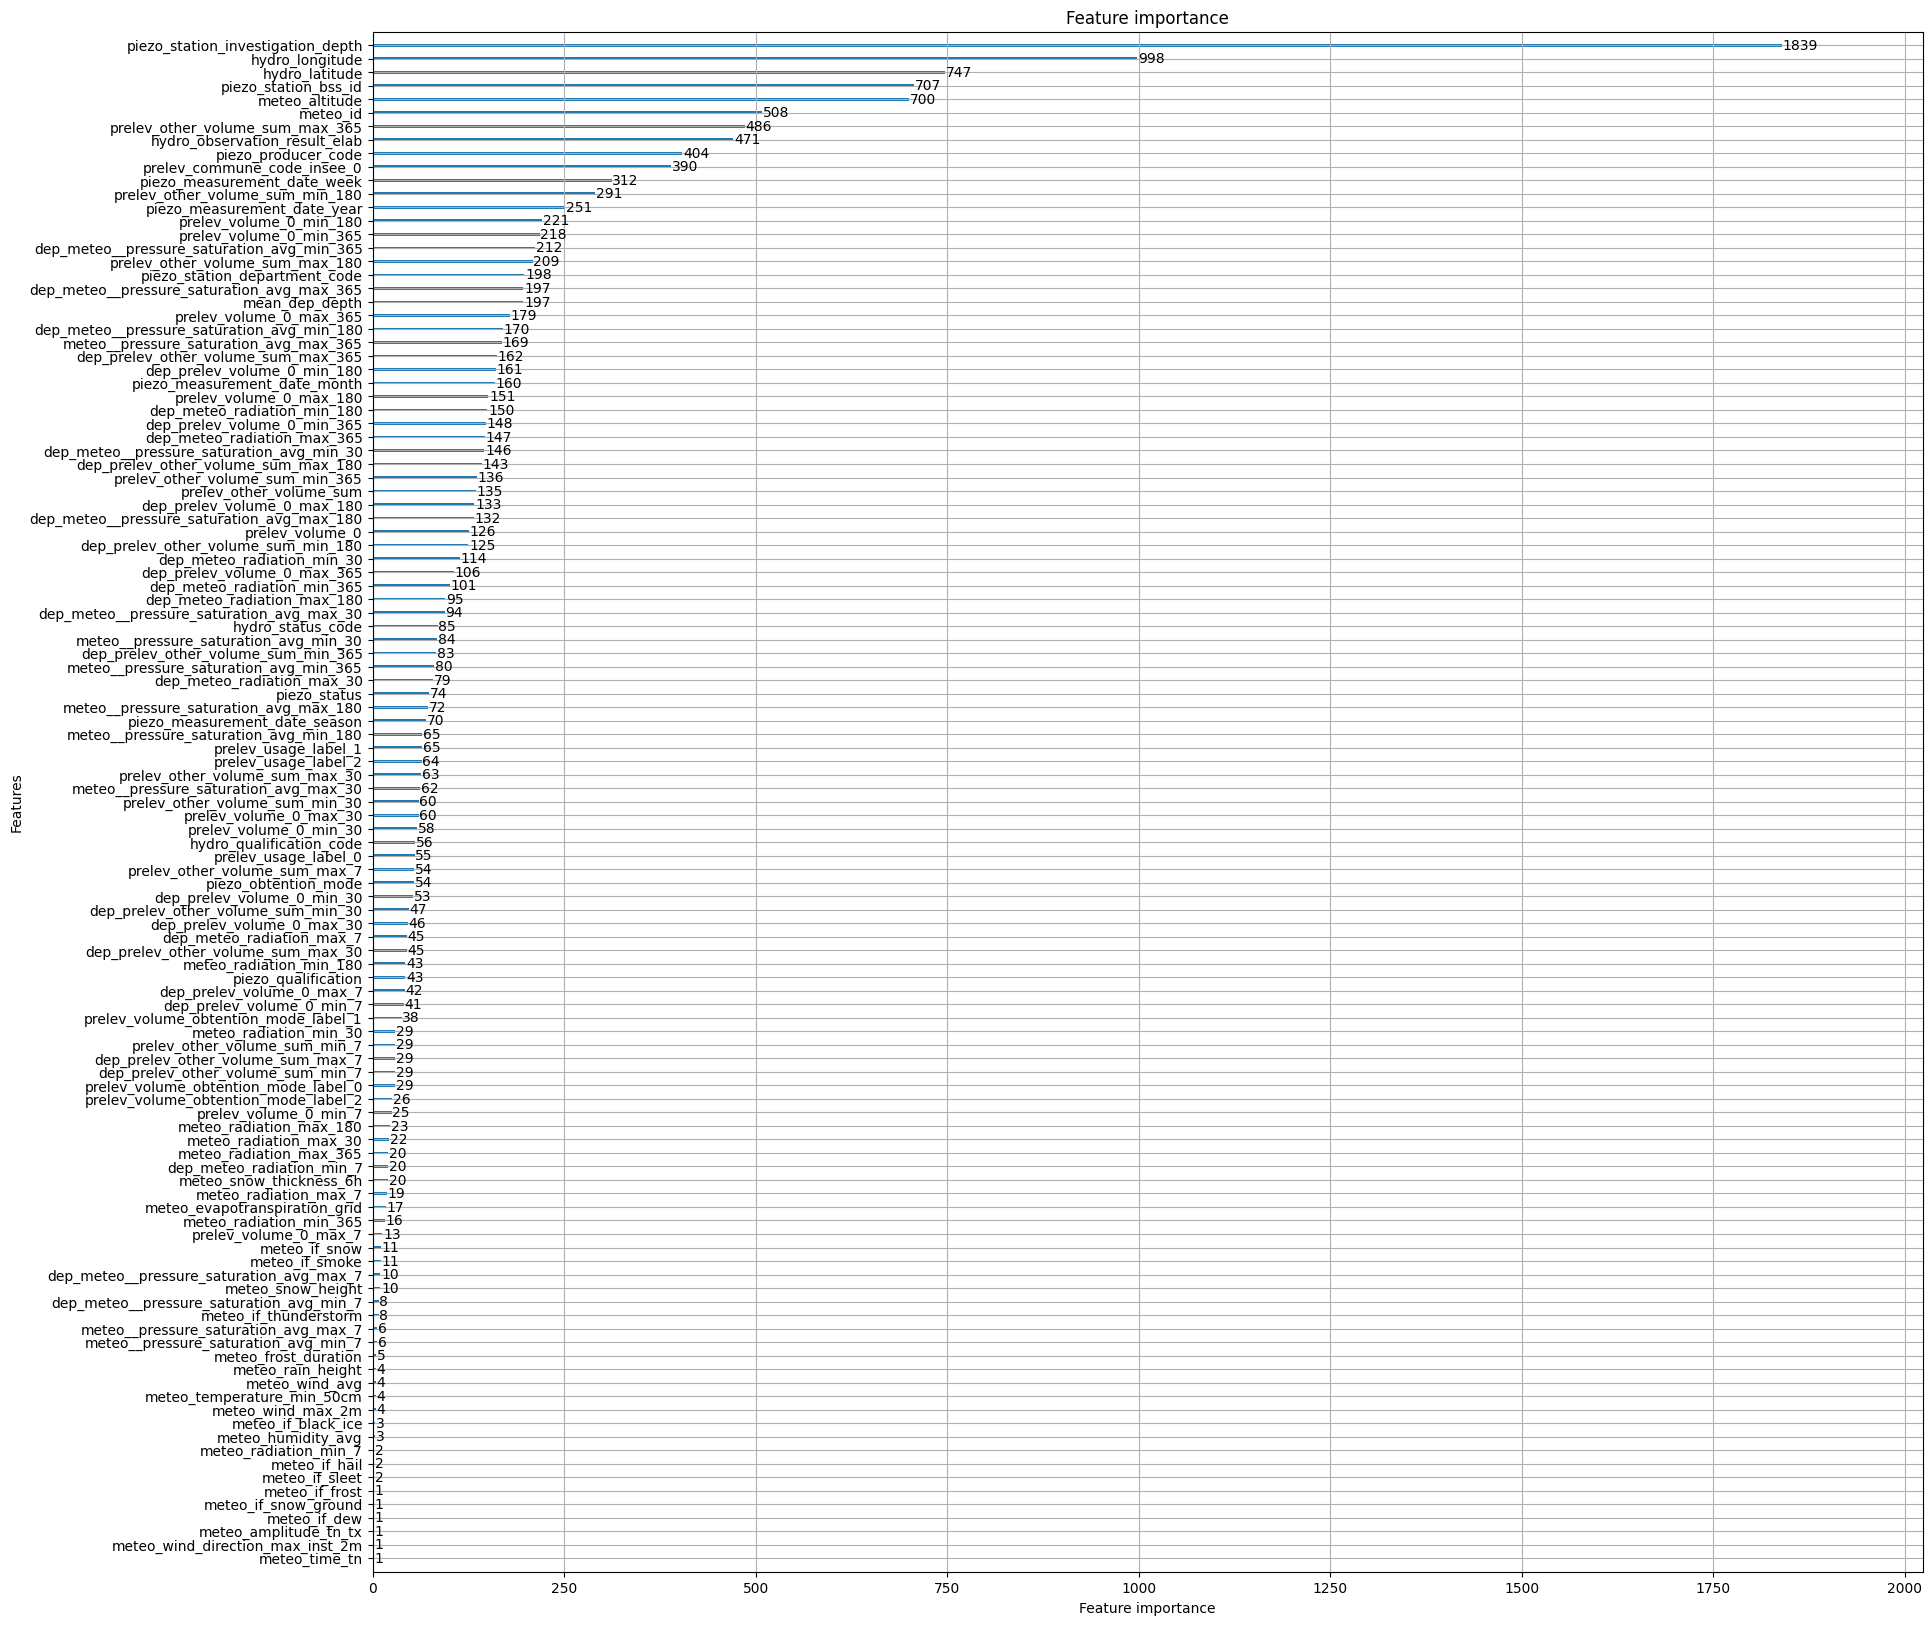

In [82]:
plot_importance(model, figsize=(20, 20));

In [88]:
important_feats = [(col, _) for _, col in sorted(list(zip(model.feature_importances_, feats)))[50:]]
important_feats

[('meteo_radiation_max_365', 20),
 ('meteo_snow_thickness_6h', 20),
 ('meteo_radiation_max_30', 22),
 ('meteo_radiation_max_180', 23),
 ('prelev_volume_0_min_7', 25),
 ('prelev_volume_obtention_mode_label_2', 26),
 ('dep_prelev_other_volume_sum_max_7', 29),
 ('dep_prelev_other_volume_sum_min_7', 29),
 ('meteo_radiation_min_30', 29),
 ('prelev_other_volume_sum_min_7', 29),
 ('prelev_volume_obtention_mode_label_0', 29),
 ('prelev_volume_obtention_mode_label_1', 38),
 ('dep_prelev_volume_0_min_7', 41),
 ('dep_prelev_volume_0_max_7', 42),
 ('meteo_radiation_min_180', 43),
 ('piezo_qualification', 43),
 ('dep_meteo_radiation_max_7', 45),
 ('dep_prelev_other_volume_sum_max_30', 45),
 ('dep_prelev_volume_0_max_30', 46),
 ('dep_prelev_other_volume_sum_min_30', 47),
 ('dep_prelev_volume_0_min_30', 53),
 ('piezo_obtention_mode', 54),
 ('prelev_other_volume_sum_max_7', 54),
 ('prelev_usage_label_0', 55),
 ('hydro_qualification_code', 56),
 ('prelev_volume_0_min_30', 58),
 ('prelev_other_volume_su

In [89]:
important_feats = [col for col, _ in important_feats]
len(important_feats)

84

In [90]:
%%time 


model = LGBMClassifier()
le = LabelEncoder()

X_train = df[important_feats]
X_test = test[important_feats]

y_train = le.fit_transform(df[TARGET])

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(classification_report(y_train, y_pred_train))

test['piezo_groundwater_level_category'] = le.inverse_transform(y_pred_test)
test[['row_index', 'piezo_groundwater_level_category']].to_csv('baseline_important_feats.csv', index=False)

              precision    recall  f1-score   support

           0       0.53      0.45      0.49    649372
           1       0.50      0.51      0.51    581989
           2       0.50      0.53      0.52    629817
           3       0.62      0.62      0.62    431841
           4       0.62      0.69      0.65    537053

    accuracy                           0.55   2830072
   macro avg       0.56      0.56      0.56   2830072
weighted avg       0.55      0.55      0.55   2830072

CPU times: user 13min 28s, sys: 10.9 s, total: 13min 39s
Wall time: 1min 31s


In [91]:
import json 


with open('imp_feats.json', 'w') as f:
    json.dump(important_feats, f)

In [92]:
# Let's tune a bit
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2)
train_df.shape, val_df.shape

((2264057, 139), (566015, 139))

In [94]:
X_train = train_df[important_feats]
X_val = val_df[important_feats]
y_train = le.fit_transform(train_df[TARGET])
y_val = le.fit_transform(val_df[TARGET])

In [95]:
%%time 

model = LGBMClassifier()

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.53      0.45      0.49    519258
           1       0.50      0.50      0.50    465760
           2       0.51      0.53      0.52    504080
           3       0.62      0.61      0.61    345224
           4       0.63      0.69      0.66    429735

    accuracy                           0.55   2264057
   macro avg       0.56      0.56      0.56   2264057
weighted avg       0.55      0.55      0.55   2264057

              precision    recall  f1-score   support

           0       0.52      0.45      0.48    130114
           1       0.50      0.50      0.50    116229
           2       0.50      0.53      0.51    125737
           3       0.61      0.61      0.61     86617
           4       0.63      0.69      0.66    107318

    accuracy                           0.55    566015
   macro avg       0.55      0.56      0.55    566015
weighted avg       0.55      0.55      0.55    566015

CPU times: user 12min 

In [98]:
from sklearn.ensemble import RandomForestClassifier

In [100]:
%%time 

model = RandomForestClassifier(n_jobs=-1)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    519258
           1       1.00      1.00      1.00    465760
           2       1.00      1.00      1.00    504080
           3       1.00      1.00      1.00    345224
           4       1.00      1.00      1.00    429735

    accuracy                           1.00   2264057
   macro avg       1.00      1.00      1.00   2264057
weighted avg       1.00      1.00      1.00   2264057

              precision    recall  f1-score   support

           0       0.93      0.93      0.93    130114
           1       0.93      0.93      0.93    116229
           2       0.94      0.94      0.94    125737
           3       0.96      0.95      0.96     86617
           4       0.97      0.97      0.97    107318

    accuracy                           0.94    566015
   macro avg       0.94      0.94      0.94    566015
weighted avg       0.94      0.94      0.94    566015

CPU times: user 1h 6mi

In [102]:
%%time
# Train full model for fun

model = RandomForestClassifier(n_jobs=-1)
le = LabelEncoder()

X_train = df[important_feats]
X_test = test[important_feats]

y_train = le.fit_transform(df[TARGET])

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(classification_report(y_train, y_pred_train))

test['piezo_groundwater_level_category'] = le.inverse_transform(y_pred_test)
test[['row_index', 'piezo_groundwater_level_category']].to_csv('rf_new_features.csv', index=False)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    649372
           1       1.00      1.00      1.00    581989
           2       1.00      1.00      1.00    629817
           3       1.00      1.00      1.00    431841
           4       1.00      1.00      1.00    537053

    accuracy                           1.00   2830072
   macro avg       1.00      1.00      1.00   2830072
weighted avg       1.00      1.00      1.00   2830072



OSError: [Errno 28] No space left on device

In [103]:
test['piezo_groundwater_level_category'] = le.inverse_transform(y_pred_test)
test[['row_index', 'piezo_groundwater_level_category']].to_csv('rf_new_features.csv', index=False)